## **Vehicle Detection Project**

### Import section

In [1]:
from skimage.feature import hog
from sklearn.svm import LinearSVC
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from scipy.ndimage.measurements import label
import AdvancedLaneLines as lanes
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
from moviepy.editor import VideoFileClip
from IPython.display import HTML
import numpy as np
import pickle
import cv2
import glob
import time

from tqdm import tqdm

%matplotlib inline

### Utility functions

Mostly used from lesson as is, but there are some changes and modifications like changes in default parameters due to deprecation warnings, adjyustment some parameters etc.


In [2]:
def get_hog_features(img, orient, pix_per_cell, cell_per_block, 
                        vis=False, feature_vec=True):
    # Call with two outputs if vis==True
    if vis == True:
        features, hog_image = hog(img, orientations=orient, 
                                  pixels_per_cell=(pix_per_cell, pix_per_cell),
                                  cells_per_block=(cell_per_block, cell_per_block), 
                                  transform_sqrt=False, 
                                  visualise=vis, feature_vector=feature_vec)
        return features, hog_image
    # Otherwise call with one output
    else:      
        features = hog(img, orientations=orient, 
                       pixels_per_cell=(pix_per_cell, pix_per_cell),
                       cells_per_block=(cell_per_block, cell_per_block), 
                       transform_sqrt=False, 
                       visualise=vis, feature_vector=feature_vec)
        return features

# Define a function to compute binned color features  
def bin_spatial(img, size=(32, 32)):
    # Use cv2.resize().ravel() to create the feature vector
    features = cv2.resize(img, size).ravel() 
    # Return the feature vector
    return features

# Define a function to compute color histogram features 
# NEED TO CHANGE bins_range if reading .png files with mpimg!
def color_hist(img, nbins=32, bins_range=(0, 256)):
    # Compute the histogram of the color channels separately
    channel1_hist = np.histogram(img[:,:,0], bins=nbins, range=bins_range)
    channel2_hist = np.histogram(img[:,:,1], bins=nbins, range=bins_range)
    channel3_hist = np.histogram(img[:,:,2], bins=nbins, range=bins_range)
    # Concatenate the histograms into a single feature vector
    hist_features = np.concatenate((channel1_hist[0], channel2_hist[0], channel3_hist[0]))

    # Return the individual histograms, bin_centers and feature vector
    return hist_features


### Extract features from training images (Car and Non-Car)

Modified by using only HOG features as most efficient (test images have different colors, brightness, color deepness)

In [3]:
# Define a function to extract features from a list of images
# Have this function call bin_spatial() and color_hist()
# Leave only HOG parameters
def extract_features(imgs, color_space='RGB', orient=9, pix_per_cell=8, cell_per_block=2, hog_channel=0):
    # Create a list to append feature vectors to
    features = []
    # Iterate through the list of images
    images_pbar = tqdm(imgs, 'Extracting features', unit='images')
    for file in images_pbar:
        # Read in each one by one
        image = mpimg.imread(file)
        # apply color conversion if other than 'RGB'
        if color_space != 'RGB':
            if color_space == 'HSV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HSV)
            elif color_space == 'LUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2LUV)
            elif color_space == 'HLS':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2HLS)
            elif color_space == 'YUV':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YUV)
            elif color_space == 'YCrCb':
                feature_image = cv2.cvtColor(image, cv2.COLOR_RGB2YCrCb)
        else: feature_image = np.copy(image)      

        # Call get_hog_features() with vis=False, feature_vec=True
        if hog_channel == 'ALL':
            hog_features = []
            for channel in range(feature_image.shape[2]):
                hog_features.append(get_hog_features(feature_image[:,:,channel], 
                                    orient, pix_per_cell, cell_per_block, 
                                    vis=False, feature_vec=True))
            hog_features = np.ravel(hog_features)        
        else:
            hog_features = get_hog_features(feature_image[:,:,hog_channel], orient, 
                        pix_per_cell, cell_per_block, vis=False, feature_vec=True)
        # Append the new feature vector to the features list
        features.append(hog_features)
    # Return list of feature vectors
    return features


### Loading training data

In [4]:
#Read in cars and notcars
car_images = glob.glob('classify-images/vehicles/**/*.png')
notcar_images = glob.glob('classify-images/non-vehicles/**/*.png')
print('Found car images: ' + str(len(car_images)))
print('Found non car images: ' + str(len(notcar_images)))


Found car images: 8792
Found non car images: 8968


### Some training data visualization

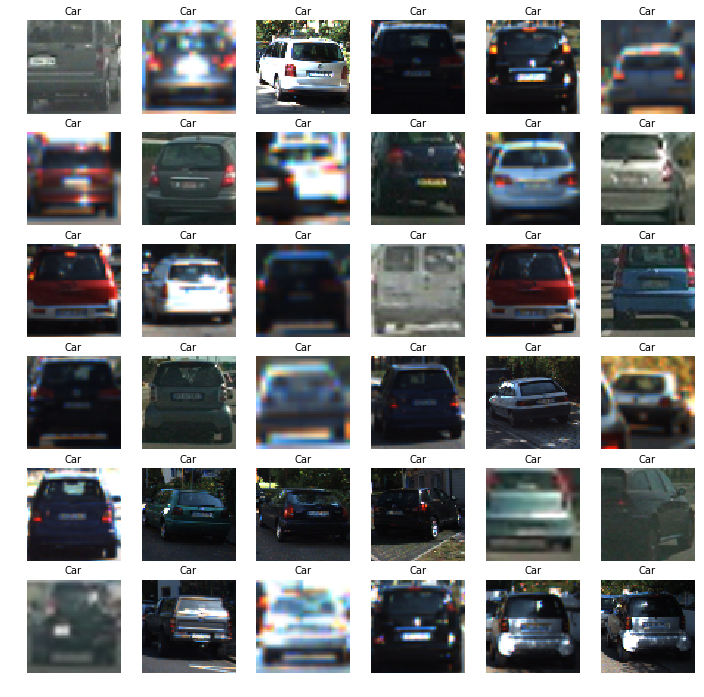

In [5]:
fig, ax = plt.subplots(6, 6, figsize=(12, 12))
ax = ax.ravel()

for i in range(36):
    img = mpimg.imread(car_images[np.random.randint(0, len(car_images))])
    ax[i].axis('off')
    ax[i].set_title('Car', fontsize=10)
    ax[i].imshow(img)


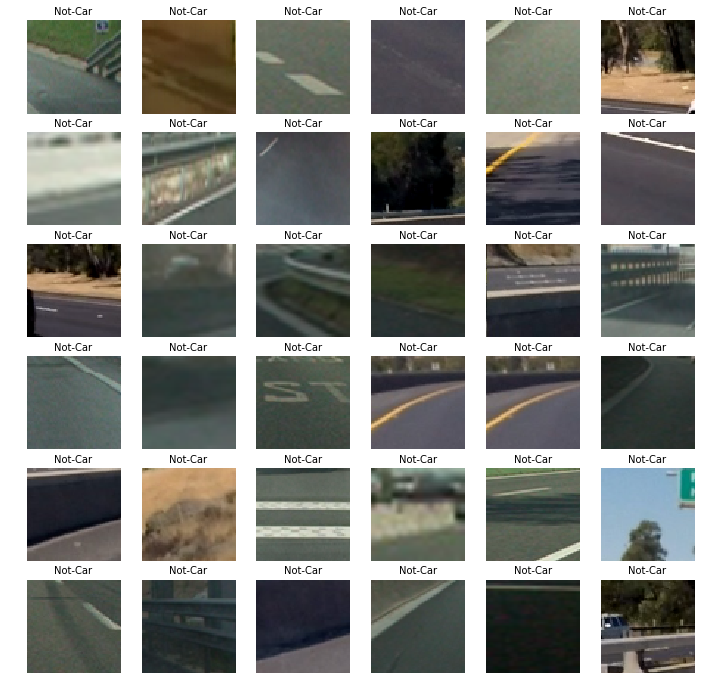

In [6]:
fig, ax = plt.subplots(6, 6, figsize=(12, 12))
ax = ax.ravel()

for i in range(36):
    img = mpimg.imread(notcar_images[np.random.randint(0, len(notcar_images))])
    ax[i].axis('off')
    ax[i].set_title('Not-Car', fontsize=10)
    ax[i].imshow(img)

### HOG extract features visualization


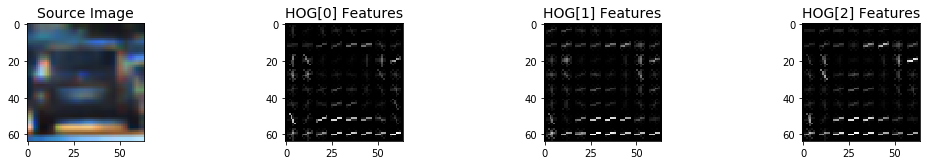

In [7]:
#Select random image
fname = car_images[np.random.randint(0, len(car_images))]
name = fname.split('\\')[-1].split('.')
img = mpimg.imread(fname)
hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

_, dst1 = get_hog_features(hog_img[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
_, dst2 = get_hog_features(hog_img[:,:,1], 9, 8, 2, vis=True, feature_vec=True)
_, dst3 = get_hog_features(hog_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
f.subplots_adjust(hspace = 1, wspace=1.2)
ax1.imshow(img)
#mpimg.imsave('output_images/car_original.' + name[1], img, cmap='gray')
ax1.set_title('Source Image', fontsize=14)
ax2.imshow(dst1, cmap='gray')
#mpimg.imsave('output_images/car_hog1.' + name[1], dst1, cmap='gray')
ax2.set_title('HOG[0] Features', fontsize=14)
ax3.imshow(dst2, cmap='gray')
#mpimg.imsave('output_images/car_hog2.' + name[1], dst2, cmap='gray')
ax3.set_title('HOG[1] Features', fontsize=14)
ax4.imshow(dst3, cmap='gray')
#mpimg.imsave('output_images/car_hog3.' + name[1], dst3, cmap='gray')
ax4.set_title('HOG[2] Features', fontsize=14)


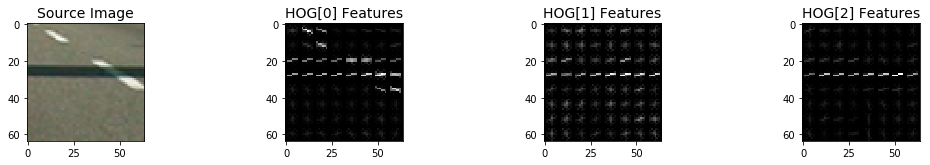

In [8]:
#Select random image
fname = notcar_images[np.random.randint(0, len(notcar_images))]
name = fname.split('\\')[-1].split('.')
img = mpimg.imread(fname)
hog_img = cv2.cvtColor(img, cv2.COLOR_RGB2YCrCb)

_, dst1 = get_hog_features(hog_img[:,:,0], 9, 8, 2, vis=True, feature_vec=True)
_, dst2 = get_hog_features(hog_img[:,:,1], 9, 8, 2, vis=True, feature_vec=True)
_, dst3 = get_hog_features(hog_img[:,:,2], 9, 8, 2, vis=True, feature_vec=True)

# Visualize 
f, (ax1, ax2, ax3, ax4) = plt.subplots(1, 4, figsize=(16, 5))
f.subplots_adjust(hspace = 1, wspace=1.2)
ax1.imshow(img)
#mpimg.imsave('output_images/not_car_original.' + name[1], img, cmap='gray')
ax1.set_title('Source Image', fontsize=14)
ax2.imshow(dst1, cmap='gray')
#mpimg.imsave('output_images/not_car_hog1.' + name[1], dst1, cmap='gray')
ax2.set_title('HOG[0] Features', fontsize=14)
ax3.imshow(dst2, cmap='gray')
#mpimg.imsave('output_images/not_car_hog2.' + name[1], dst2, cmap='gray')
ax3.set_title('HOG[1] Features', fontsize=14)
ax4.imshow(dst3, cmap='gray')
#mpimg.imsave('output_images/not_car_hog3.' + name[1], dst3, cmap='gray')
ax4.set_title('HOG[2] Features', fontsize=14)


### Extract features

Extracting HOG features from train image sets, split sets into train and test sub-sets

In [9]:
colorspace = 'YUV' # Can be RGB, HSV, LUV, HLS, YUV, YCrCb
orient = 11
pix_per_cell = 16
cell_per_block = 2
hog_channel = 'ALL' # Can be 0, 1, 2, or "ALL"

t = time.time()
car_features = extract_features(car_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
notcar_features = extract_features(notcar_images, color_space=colorspace, orient=orient, 
                        pix_per_cell=pix_per_cell, cell_per_block=cell_per_block, 
                        hog_channel=hog_channel)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to extract HOG features...')

X = np.vstack((car_features, notcar_features)).astype(np.float64)
# Fit a per-column scaler - only if used several types of features like HOG, color histogramm, spatial
#X_scaler = StandardScaler().fit(X)
# Apply the scaler to X
#scaled_X = X_scaler.transform(X)
   
# Define the labels vector
y = np.hstack((np.ones(len(car_features)), np.zeros(len(notcar_features))))
   
# Split up data into randomized training and test sets
rand_state = np.random.randint(0, 100)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=rand_state)
# Shuffle
#X_train, y_train = shuffle(X_train, y_train)
#X_test, y_test = shuffle(X_test, y_test)
   
print('Using:',orient,'orientations',pix_per_cell,
    'pixels per cell and', cell_per_block,'cells per block')
print('Feature vector length:', len(X_train[0]))


Extracting features: 100%|████████████| 8968/8968 [00:34<00:00, 260.56images/s]


68.47 Seconds to extract HOG features...
Using: 11 orientations 16 pixels per cell and 2 cells per block
Feature vector length: 1188


### Train a classifier

In [10]:
# Use a linear SVC 
svc = LinearSVC()
# Check the training time for the SVC
t = time.time()
svc.fit(X_train, y_train)
t2 = time.time()
print(round(t2-t, 2), 'Seconds to train SVC...')
# Check the score of the SVC
print('Test Accuracy of SVC = ', round(svc.score(X_test, y_test), 4))
# Check the prediction time for a single sample
n_predict = 20
print('SVC predicts: ', svc.predict(X_test[0:n_predict]))
print('For ', n_predict, 'labels: ', y_test[0:n_predict])


1.75 Seconds to train SVC...
Test Accuracy of SVC =  0.984
SVC predicts:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.
  1.  0.]
For  20 labels:  [ 1.  0.  0.  1.  0.  1.  1.  0.  0.  0.  1.  1.  1.  1.  0.  0.  0.  1.
  1.  0.]


### Utility functions todrawing windows on test image

In [11]:
# Define a function to draw bounding boxes
def draw_boxes(img, bboxes, color=(0, 0, 255), thick=6):
    # Make a copy of the image
    imcopy = np.copy(img)
    # Iterate through the bounding boxes
    for bbox in bboxes:
        # Draw a rectangle given bbox coordinates
        cv2.rectangle(imcopy, bbox[0], bbox[1], color, thick)
    # Return the image copy with boxes drawn
    return imcopy


### Function to find cars in image

Modified function from lesson

In [12]:
# Define a single function that can extract features using hog sub-sampling and make predictions
def find_cars(img, ystart, ystop, scale, cspace, svc, orient, pix_per_cell, cell_per_block, hog_channel, print_all=False):
    rectangles = []
    img = img.astype(np.float32)/255
    
    xstart=100
    xstop=1280
    img_tosearch = img[ystart:ystop,xstart:xstop,:]
    # apply color conversion if other than 'RGB'
    if cspace != 'RGB':
        if cspace == 'HSV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HSV)
        elif cspace == 'LUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2LUV)
        elif cspace == 'HLS':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2HLS)
        elif cspace == 'YUV':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YUV)
        elif cspace == 'YCrCb':
            ctrans_tosearch = cv2.cvtColor(img_tosearch, cv2.COLOR_RGB2YCrCb)
    else: ctrans_tosearch = np.copy(image)

    if scale != 1:
        imshape = ctrans_tosearch.shape
        ctrans_tosearch = cv2.resize(ctrans_tosearch, (np.int(imshape[1]/scale), np.int(imshape[0]/scale)))
        
    ch1 = ctrans_tosearch[:,:,0]
    ch2 = ctrans_tosearch[:,:,1]
    ch3 = ctrans_tosearch[:,:,2]

    # Define blocks and steps as above
    nxblocks = (ch1.shape[1] // pix_per_cell) + 1
    nyblocks = (ch1.shape[0] // pix_per_cell) + 1
    nfeat_per_block = orient*cell_per_block**2
    # 64 was the orginal sampling rate, with 8 cells and 8 pix per cell
    window = 64
    nblocks_per_window = (window // pix_per_cell) - 1 
    cells_per_step = 2  # Instead of overlap, define how many cells to step
    nxsteps = (nxblocks - nblocks_per_window) // cells_per_step
    nysteps = (nyblocks - nblocks_per_window) // cells_per_step
    
    # Compute individual channel HOG features for the entire image
    if hog_channel == 'ALL':
        hog1 = get_hog_features(ch1, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog2 = get_hog_features(ch2, orient, pix_per_cell, cell_per_block, feature_vec=False)
        hog3 = get_hog_features(ch3, orient, pix_per_cell, cell_per_block, feature_vec=False)
    else:
        hog = get_hog_features(hog_channel, orient, pix_per_cell, cell_per_block, feature_vec=False)
    
    for xb in range(nxsteps):
        for yb in range(nysteps):
            ypos = yb*cells_per_step
            xpos = xb*cells_per_step
            
            xleft = xpos*pix_per_cell
            ytop = ypos*pix_per_cell

            # Extract HOG for this patch
            if hog_channel == 'ALL':
                hog_feat1 = hog1[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat2 = hog2[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_feat3 = hog3[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel() 
                hog_features = np.hstack((hog_feat1, hog_feat2, hog_feat3))
            else:
                hog_features = hog[ypos:ypos+nblocks_per_window, xpos:xpos+nblocks_per_window].ravel()
            
            test_prediction = svc.predict(hog_features)
            
            if test_prediction == 1 or print_all == True:
                xbox_left = xstart+np.int(xleft*scale)
                ytop_draw = np.int(ytop*scale)
                win_draw = np.int(window*scale)
                rectangles.append(((int(xbox_left), int(ytop_draw+ystart)),(int(xbox_left+win_draw),int(ytop_draw+win_draw+ystart))))
                
    return rectangles



Processing: 100%|████████████████████████████| 6/6 [00:01<00:00,  4.12images/s]


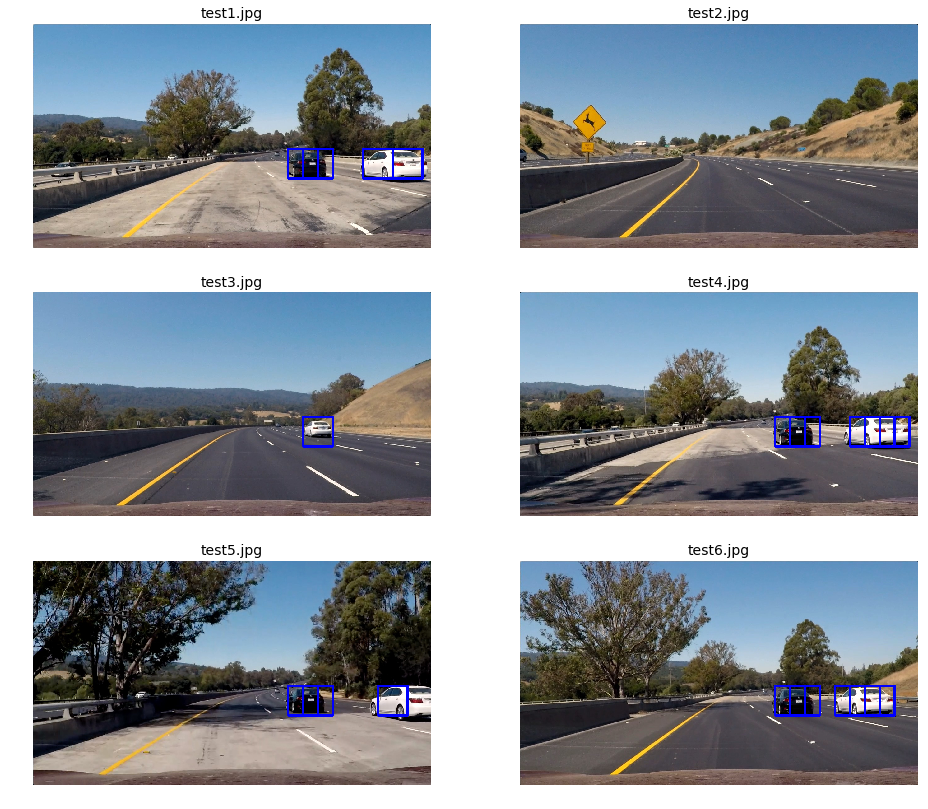

In [13]:
test_images = glob.glob('test_images/test*.jpg')
images_pbar = tqdm(test_images, 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for i, image_file in enumerate(images_pbar):
    image = mpimg.imread(image_file)
    draw_image = np.copy(image)
    rectangles = find_cars(image, 400, 640, 1.5, colorspace, svc, orient, pix_per_cell, cell_per_block, hog_channel)
    window_image = draw_boxes(draw_image, rectangles, color=(0, 0, 255), thick=6)  
    axes[i].imshow(window_image)
    axes[i].set_title(image_file.split('\\')[-1], fontsize=14)
    axes[i].axis('off')    


### Search areas in image frame

Defining areas for call `find_cars` function to avoid search in unexpected areas and improve performance. Specifiying different scales also improves reliability of predictions 

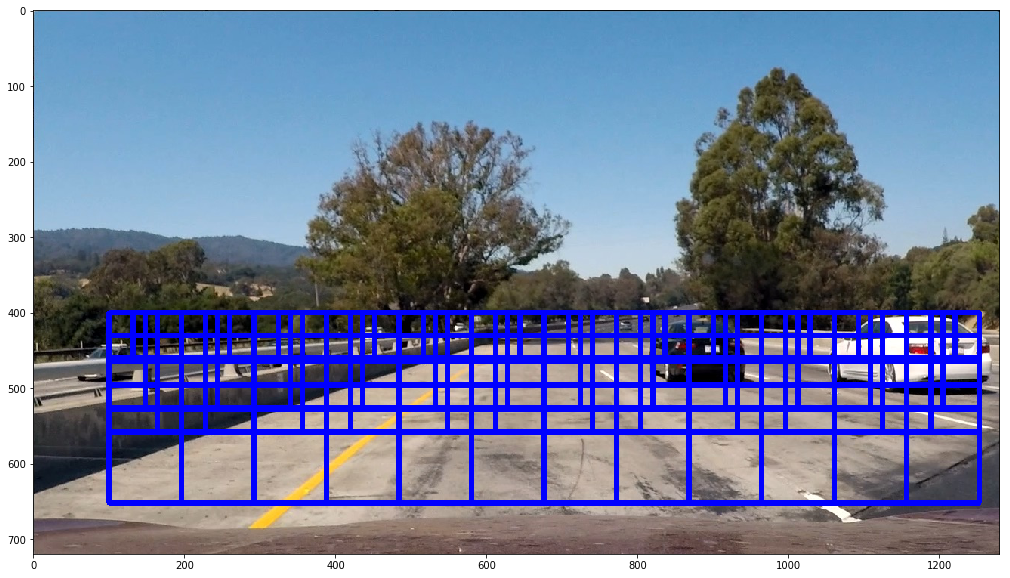

In [14]:
locations = []
locations.append({ 'ystart': 400, 'ystop': 465, 'scale': 1.0 })
locations.append({ 'ystart': 420, 'ystop': 480, 'scale': 1.0 })
locations.append({ 'ystart': 400, 'ystop': 500, 'scale': 1.5 })
locations.append({ 'ystart': 430, 'ystop': 530, 'scale': 1.5 })
locations.append({ 'ystart': 400, 'ystop': 530, 'scale': 2.0 })
locations.append({ 'ystart': 430, 'ystop': 560, 'scale': 2.0 })
locations.append({ 'ystart': 400, 'ystop': 560, 'scale': 3.0 })
locations.append({ 'ystart': 460, 'ystop': 660, 'scale': 3.0 })
locations.append({ 'ystart': 400, 'ystop': 600, 'scale': 3.5 })
locations.append({ 'ystart': 465, 'ystop': 660, 'scale': 3.5 })
locations = np.array(locations)

image = mpimg.imread('test_images/test1.jpg')
window_img = np.copy(image)

rectangle_list = []
    
for location in locations:
    ystart = location['ystart']
    ystop = location['ystop']
    scale = location['scale']
    rectangle_list.append(find_cars(image, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block, hog_channel, print_all=True))
    
rectangles = []
for sub_list in rectangle_list:
    for rectangle in sub_list:
        rectangles.append(rectangle)

window_img = draw_boxes(window_img, rectangles, color=(0, 0, 255), thick=6)
image = mpimg.imsave('output_images/all_search_areas.jpg', window_img)
plt.figure(figsize = (20, 10))
plt.imshow(window_img)


### Heat functions

In [15]:
def add_heat(heatmap, bbox_list):
    # Iterate through list of bboxes
    for box in bbox_list:
        # Add += 1 for all pixels inside each bbox
        # Assuming each "box" takes the form ((x1, y1), (x2, y2))
        heatmap[box[0][1]:box[1][1], box[0][0]:box[1][0]] += 1

    # Return updated heatmap
    return heatmap
    
def apply_threshold(heatmap, threshold):
    heatmap_threshold = np.copy(heatmap)
    # Zero out pixels below the threshold
    heatmap_threshold[heatmap_threshold <= threshold] = 0
    # Return thresholded map
    return heatmap_threshold

def draw_labeled_bboxes(img, labels, color=(0, 0, 255), thick=6):
    # Iterate through all detected cars
    for car_number in range(1, labels[1]+1):
        # Find pixels with each car_number label value
        nonzero = (labels[0] == car_number).nonzero()
        # Identify x and y values of those pixels
        nonzeroy = np.array(nonzero[0])
        nonzerox = np.array(nonzero[1])
        # Define a bounding box based on min/max x and y
        bbox = ((np.min(nonzerox), np.min(nonzeroy)), (np.max(nonzerox), np.max(nonzeroy)))
        # Draw the box on the image
        cv2.rectangle(img, bbox[0], bbox[1], color, thick)
    # Return the image
    return img


### Testing finding car function on on of test images

Processing: 100%|████████████████████████████| 6/6 [00:03<00:00,  1.92images/s]


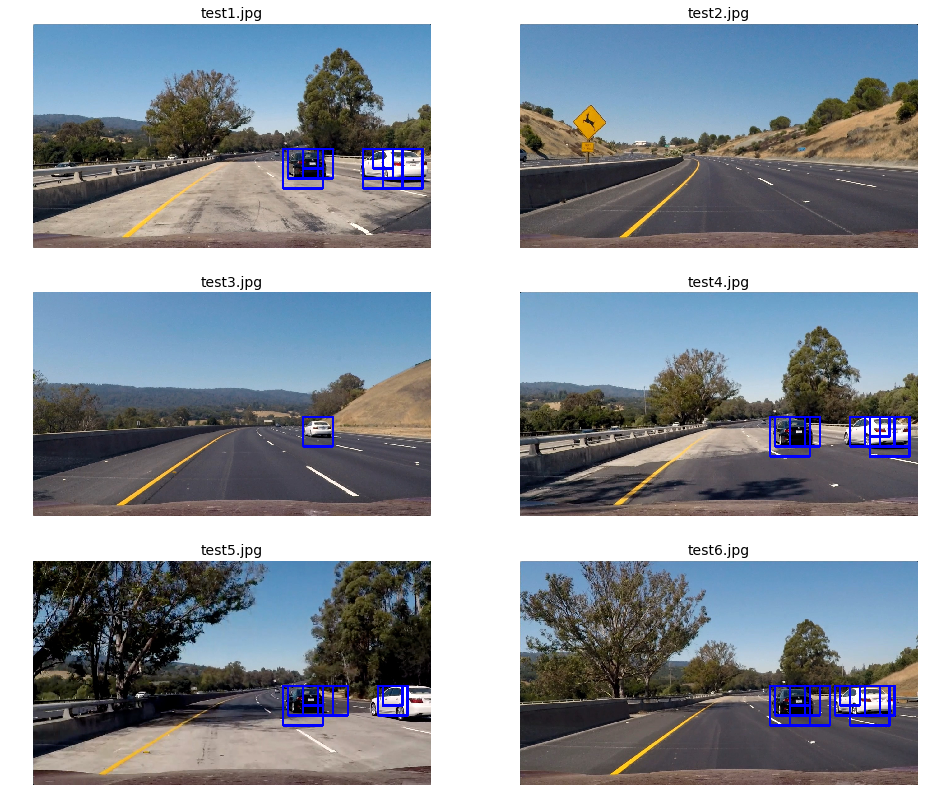

In [16]:
test_images = glob.glob('test_images/test*.jpg')
images_pbar = tqdm(test_images, 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for i, image_file in enumerate(images_pbar):
    image = mpimg.imread(image_file)
    rectangle_list = []
    
    for location in locations:
        ystart = location['ystart']
        ystop = location['ystop']
        scale = location['scale']
        rectangle_list.append(find_cars(image, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block, hog_channel))
    
    rectangles = []
    for sub_list in rectangle_list:
        for rectangle in sub_list:
            rectangles.append(rectangle)

    draw_image = draw_boxes(np.copy(image), rectangles, color=(0, 0, 255), thick=6) 
    axes[i].imshow(draw_image)
    axes[i].set_title(image_file.split('\\')[-1], fontsize=14)
    axes[i].axis('off')

plt.savefig('output_images/find_cars_illustration.jpg')

### Visualization heat results

Processing: 100%|████████████████████████████| 6/6 [00:03<00:00,  1.92images/s]


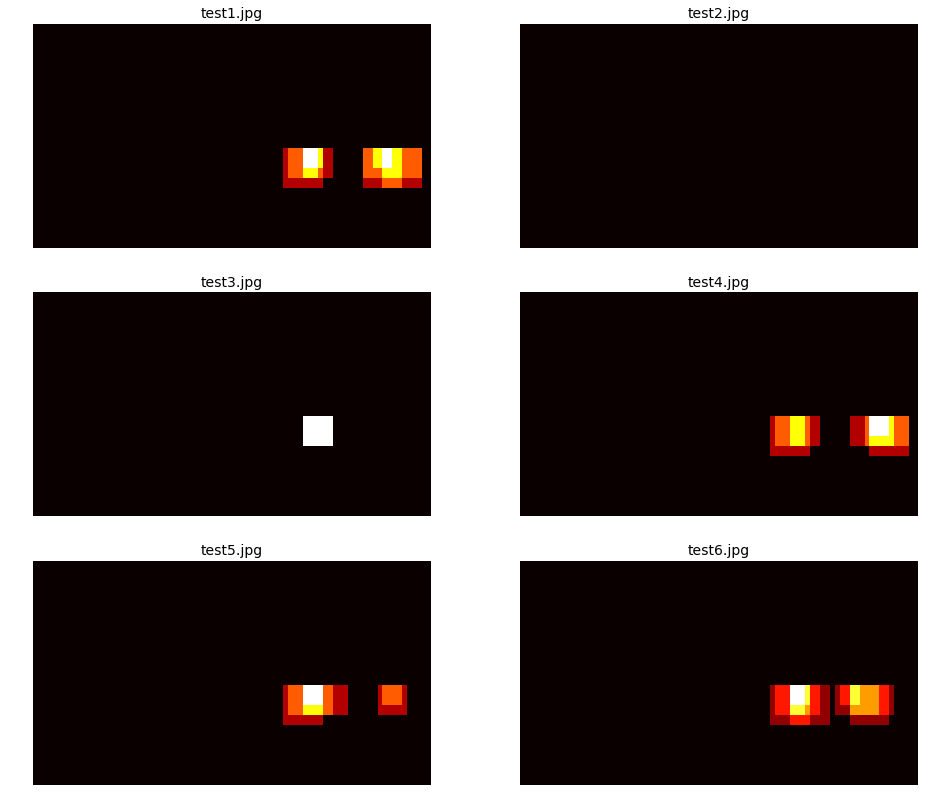

In [17]:
test_images = glob.glob('test_images/test*.jpg')
images_pbar = tqdm(test_images, 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()
heat_images = { 'name': [], 'image': [] }

for i, image_file in enumerate(images_pbar):
    image = mpimg.imread(image_file)
    heat_image = np.zeros_like(image[:,:,0]).astype(np.float)
    rectangle_list = []
    
    for location in locations:
        ystart = location['ystart']
        ystop = location['ystop']
        scale = location['scale']
        rectangle_list.append(find_cars(image, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block, hog_channel))
    
    rectangles = []
    for sub_list in rectangle_list:
        for rectangle in sub_list:
            rectangles.append(rectangle)
    
    heat_image = add_heat(heat_image, rectangles)
    name = image_file.split('\\')[-1]
    heat_images['name'].append(name)
    heat_images['image'].append(heat_image)
    axes[i].imshow(heat_image, cmap='hot')
    axes[i].set_title(name, fontsize=14)
    axes[i].axis('off')

plt.savefig('output_images/heat_illustration.jpg')


### Applying heat threshold and visualize results

Processing: 100%|████████████████████████████| 6/6 [00:00<00:00, 13.98images/s]


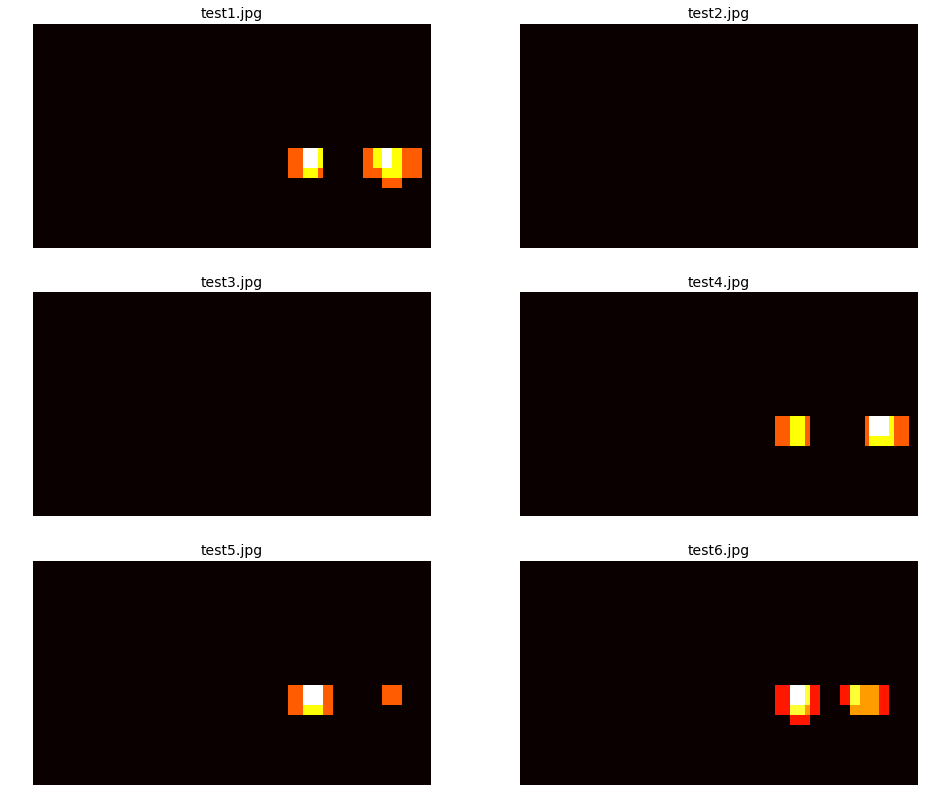

In [18]:
images_pbar = tqdm(heat_images['image'], 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()
heat_tresh_images = { 'name': [], 'image': [] }

for i, heat_image in enumerate(images_pbar):
    heat_tresh_image = apply_threshold(heat_image, 1)
    heat_tresh_images['image'].append(heat_tresh_image)
    heat_tresh_images['name'].append(heat_images['name'][i])
    axes[i].imshow(heat_tresh_image, cmap='hot')
    axes[i].set_title(heat_images['name'][i], fontsize=14)
    axes[i].axis('off')

plt.savefig('output_images/heat_tr_illustration.jpg')


### Make labeling and visualize results

Processing: 100%|████████████████████████████| 6/6 [00:00<00:00, 13.24images/s]


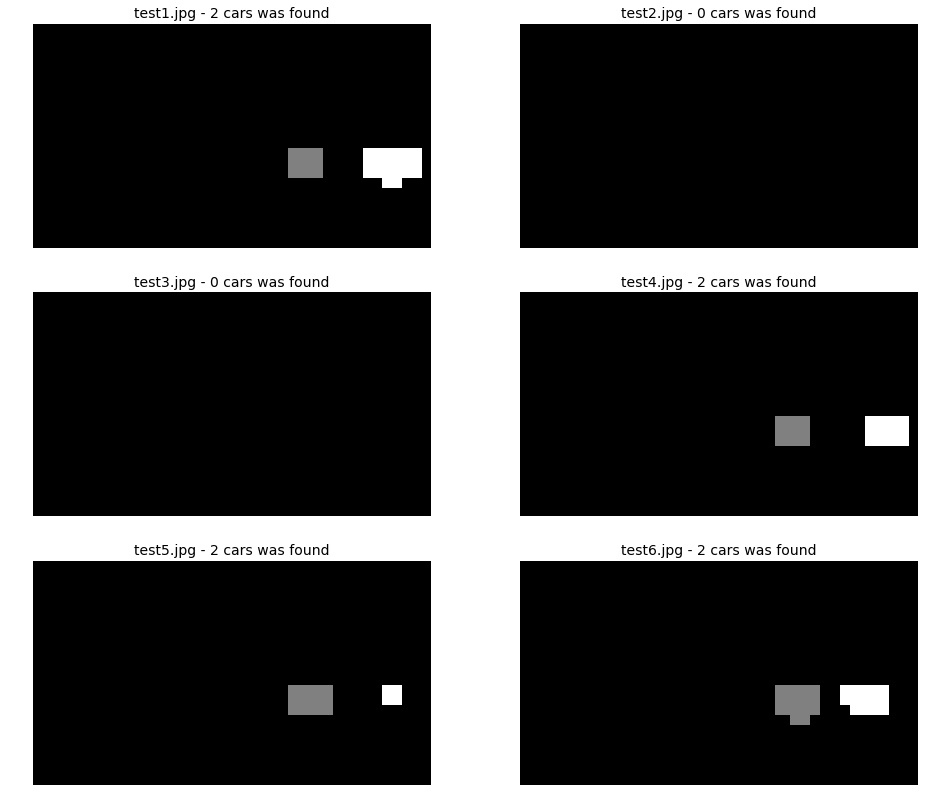

In [19]:
images_pbar = tqdm(heat_tresh_images['image'], 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()
label_images = { 'name': [], 'label': [] }

for i, heat_tresh_image in enumerate(images_pbar):
    # Visualize the heatmap when displaying    
    heatmap = np.clip(heat_tresh_image, 0, 255)
    # Find final boxes from heatmap using label function
    labels = label(heatmap)
    label_images['label'].append(labels)
    name = heat_tresh_images['name'][i] + " - " + str(labels[1]) + " cars was found"
    label_images['name'].append(name)
    axes[i].imshow(labels[0], cmap='gray')
    axes[i].set_title(name, fontsize=14)
    axes[i].axis('off')

plt.savefig('output_images/label_illustration.jpg')


### Visualize labeled image

Processing: 100%|████████████████████████████| 6/6 [00:00<00:00,  8.32images/s]


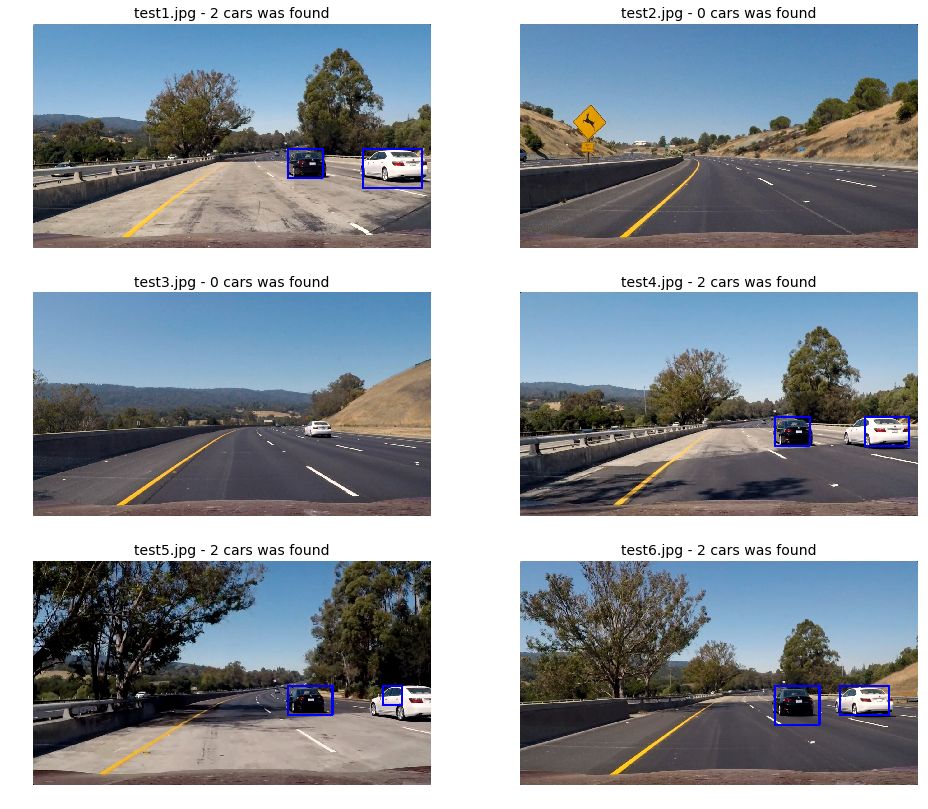

In [20]:
labels_pbar = tqdm(label_images['label'], 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for i, labels in enumerate(labels_pbar):
    image = mpimg.imread(test_images[i])
    labeled_image = draw_labeled_bboxes(np.copy(image), labels, color=(0, 0, 255), thick=6)
    axes[i].imshow(labeled_image)
    axes[i].set_title(label_images['name'][i], fontsize=14)
    axes[i].axis('off')

plt.savefig('output_images/final_illustration.jpg')


### Function to process one video frame or one image


In [21]:
def process_frame(image):
    rectangle_list = []
    
    for location in locations:
        ystart = location['ystart']
        ystop = location['ystop']
        scale = location['scale']
        rectangle_list.append(find_cars(image, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block, hog_channel))
    
    rectangles = []
    for sub_list in rectangle_list:
        for rectangle in sub_list:
            rectangles.append(rectangle)
    
    heatmap_img = np.zeros_like(image[:,:,0]).astype(np.float)

    heatmap_img = add_heat(heatmap_img, rectangles)
        
    # Apply threshold to help remove false positives
    heat_tresh_img = apply_threshold(heatmap_img, 1)
    
    # Find final boxes from heatmap using label function
    labels = label(heat_tresh_img)
    labeled_img = draw_labeled_bboxes(np.copy(image), labels, color=(0, 0, 255), thick=6)
    
    return labeled_img


Processing: 100%|████████████████████████████| 6/6 [00:03<00:00,  1.83images/s]


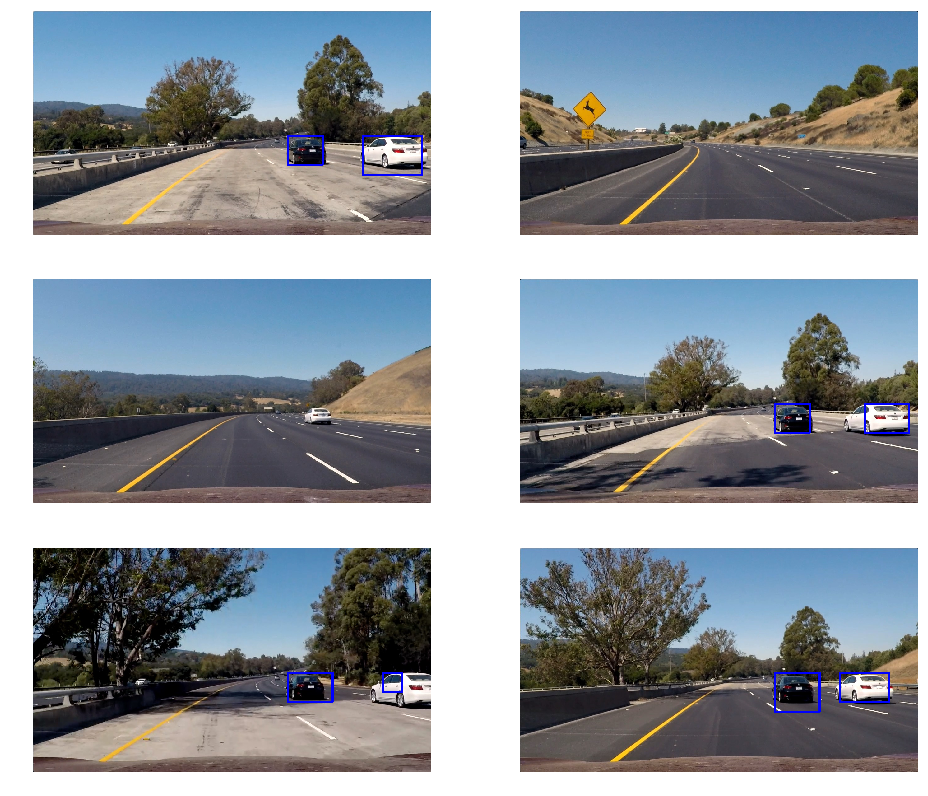

In [22]:
test_images = glob.glob('test_images/test*.jpg')
images_pbar = tqdm(test_images, 'Processing', unit='images')
fig, axes = plt.subplots(3, 2, figsize=(16, 14))
axes = axes.ravel()

for i, image_file in enumerate(images_pbar):
    image = mpimg.imread(image_file)
    draw_image = process_frame(image)
    axes[i].imshow(draw_image)
    axes[i].axis('off')    


### Function to process one video frame

Additionally storage for historical rectangles (like lane positions in [Advanced Lane Lines project](https://github.com/VolodymyrIvanov/Udacity-Advanced-Lane-Lines))
Add also lanes detection from project, mentioned above.

In [23]:
max_hist_rects = 20

def add_rects_to_history(hist_rects, new_rects):
    hist_rects.append(new_rects)
    if len(hist_rects) > max_hist_rects:
        hist_rects = hist_rects[len(hist_rects) - max_hist_rects:]
    return hist_rects
        
def process_frame_video(img):
    global hist_rects
    
    rectangle_list = []
    
    for location in locations:
        ystart = location['ystart']
        ystop = location['ystop']
        scale = location['scale']
        rectangle_list.append(find_cars(img, ystart, ystop, scale, colorspace, svc, orient, pix_per_cell, cell_per_block, hog_channel))
    
    rectangles = []
    for sub_list in rectangle_list:
        for rectangle in sub_list:
            rectangles.append(rectangle)
            
    rectangles = np.array(rectangles)
    
    if len(rectangles) > 0:
        hist_rects = add_rects_to_history(hist_rects, rectangles)
    
    heatmap_img = np.zeros_like(img[:,:,0])
    for rect_set in hist_rects:
        heatmap_img = add_heat(heatmap_img, rect_set)
    #Specify dynamically threshold
    heatmap_img = apply_threshold(heatmap_img, 1 + len(hist_rects) // 2)
     
    labels = label(heatmap_img)
    lanes_img = lanes.process_frame(np.copy(img))
    draw_img = draw_labeled_bboxes(lanes_img, labels, color=(0, 0, 255), thick=6)
    
    return draw_img


### Run a test video processing pipeline

Running extended function with historical array of rectangles

In [24]:
hist_rects = []
lanes.left_line = lanes.Line()
lanes.right_line = lanes.Line()

lanes.startedFromScratch = True
lanes.maxErrors = False
lanes.fail_iterations = 0
lanes.iteration = 0

test_video_out_file = 'output_videos/test_video.mp4'
clip_test_video = VideoFileClip('test_video.mp4')
clip_test_video_out = clip_test_video.fl_image(process_frame_video)
%time clip_test_video_out.write_videofile(test_video_out_file, audio=False)


[MoviePy] >>>> Building video output_videos/test_video.mp4
[MoviePy] Writing video output_videos/test_video.mp4


 97%|████████████████████████████████████████▉ | 38/39 [00:32<00:00,  1.19it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/test_video.mp4 

Wall time: 33.8 s


In [25]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(test_video_out_file))

### Run a project video processing pipeline

In [26]:
hist_rects = []
lanes.left_line = lanes.Line()
lanes.right_line = lanes.Line()

lanes.startedFromScratch = True
lanes.maxErrors = False
lanes.fail_iterations = 0
lanes.iteration = 0

proj_video_out_file = 'output_videos/project_video.mp4'
clip_proj_video = VideoFileClip('project_video.mp4')
clip_proj_video_out = clip_proj_video.fl_image(process_frame_video)
%time clip_proj_video_out.write_videofile(proj_video_out_file, audio=False)


[MoviePy] >>>> Building video output_videos/project_video.mp4
[MoviePy] Writing video output_videos/project_video.mp4


100%|█████████████████████████████████████▉| 1260/1261 [17:44<00:00,  1.15it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: output_videos/project_video.mp4 

Wall time: 17min 45s


In [27]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(proj_video_out_file))